In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd

In [7]:
def MEG_gradient_plusPG(X, time, N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_overall_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd, n):
    
    x=2*PLK1_conc/(2-PLK1_grad)
    PLK_conc = np.linspace((1-PLK1_grad)*x, x, N)
    
    x=2*Pase_overall_conc/(2-Pase_grad)
    Pase_conc = np.linspace(x,(1-Pase_grad)*x, N)
    
    dx=np.zeros(7*N)
    
    # array to store PG radii in each cpt
    rad = np.zeros(N)
    #print(rad)
    
    for i in range(N):
        rad[i]=((3/(4*np.pi) * ((X[i+4*N]+X[i+5*N]+X[i+6*N])*2.36*10**(-11)/N)/126)**(1/3))*(10**5)
    #print(rad)
    
    coop = np.zeros(N)
    for i in range(N):
        total_free_MEG=X[i]+X[i+N]+X[i+3*N]
        #total_free_MEG_moles=(X[i]+X[i+N]+X[i+3*N])*2.36*N**(-11)/N
        coop[i]=total_free_MEG**n/(Kd**n+total_free_MEG**n) # if cooperativity high (Sear says can be arbitrarily high for LLPS) the weak gradient can still give P granule localisation
    
    # equations for M - dx[0 to N-1] is M conc in cpts 0 to 9
    for i in range(N):
        
        if i==0:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]+Df*(X[i+1]-X[i])
        
        elif i==N-1:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]+Df*(X[i-1]-X[i])
            
        else:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]+Df*(X[i+1]+X[i-1]-2*X[i]) 
    
    # equations for MP - dx[N to 19] is M conc in cpts 0 to 9
    
    for i in range(N):
        
        if i==0:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]+Df*(X[i+N+1]-X[i+N])
        
        elif i==N-1:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]+Df*(X[i+N-1]-X[i+N])
            
        else:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]+Df*(X[i+N+1]+X[i+N-1]-2*X[i+N]) 
    
    # equations for R - dx[2*N to 29] is R conc in cpts 0 to 9
    
    for i in range(N):
        
        dx[i+2*N]=-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+kcat2_km2*PLK_conc[i]*X[i+3*N]
        
    
    # equations for MR - dx[3*N to 39] is MR conc in cpts 0 to 9
    
    for i in range(N):
        
        if i==0:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N+1]-X[i+3*N])
        
        elif i==N-1:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N-1]-X[i+3*N])
            
        else:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N+1]+X[i+3*N-1]-2*X[i+3*N]) 
    
    # equations for MR_PG - dx[4*N to 49]
    
    for i in range(N):
        
        dx[i+4*N]=r2*coop[i]*rad[i]*X[i+3*N]
    
    # equations for M_PG - dx[5*N to 59] 
        
    for i in range(N):
        
        dx[i+5*N]=r1*coop[i]*rad[i]*X[i]
    
    # equations for MP_PG - dx[6*N to 69]  
    
    for i in range(N):
        
        dx[i+6*N]=r1*coop[i]*rad[i]*X[i+N]
    
    return dx

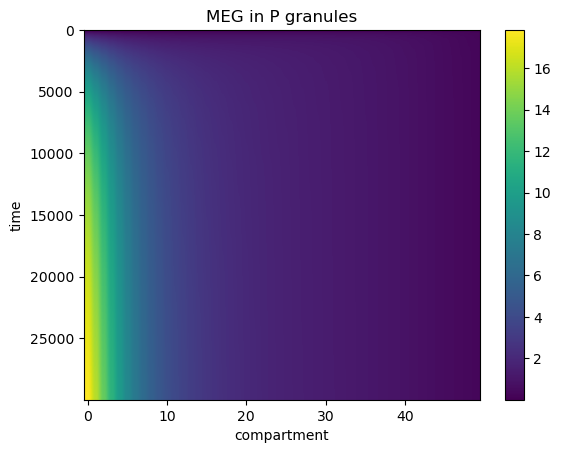

In [11]:
# first trying with params as before (see mutant phenotypes for reasoning), with Pase conc and kcat/km equal to the kinase

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*0.00001))
init=np.concatenate((init, np.zeros(2*N)))
  
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd=15
n=20

params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd, n)

sol=odeint(MEG_gradient_plusPG, init, t, params) 

total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto')
plt.title('MEG in P granules')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

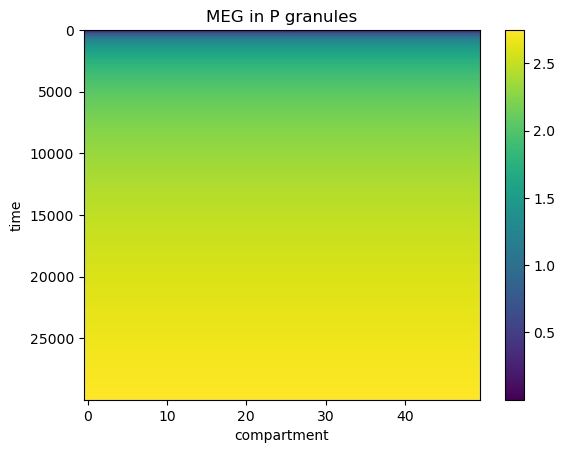

In [17]:
# mex-5 not localised -> reduce the RNA available, with no gradient. will also mean no phosphatase gradient or kinase gradient according to our model
# and phosphatase activity will be reduced

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=20
RNA_grad=0
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*0.00001))
init=np.concatenate((init, np.zeros(2*N)))
  
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0
kcat1_km1=9*10**(-5)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd=15
n=20

params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd, n)

sol=odeint(MEG_gradient_plusPG, init, t, params) 

total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto')
plt.title('MEG in P granules')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

In [138]:
# making it so need MR_PG to get phase condensation of the others (multiplying phase condensation terms of M and MP by MR_PG)
# added a leaving PG term which is essentially a reaction inhibited by the PG molecules 
# tried making PG formation cooperative dependent on R too - was causing issues, got rid of this

def need_MR_PG(X, time, N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_overall_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2):
    
    x=2*PLK1_conc/(2-PLK1_grad)
    PLK_conc = np.linspace((1-PLK1_grad)*x, x, N)
    
    x=2*Pase_overall_conc/(2-Pase_grad)
    Pase_conc = np.linspace(x,(1-Pase_grad)*x, N)
    
    dx=np.zeros(7*N)
    
    # array to store PG radii in each cpt
    rad = np.zeros(N)
    #print(rad)
    
    for i in range(N):
        base = (3/(4*np.pi) * ((X[i+4*N]+X[i+5*N]+X[i+6*N])*2.36*10**(-11)/N)/126)
        if base >= 0:
            rad[i] = (base ** (1/3)) * (10**5)
        else:
            rad[i] = 0
    #print(rad)
    
    coop = np.zeros(N)
    for i in range(N):
        total_free_MEG=X[i]+X[i+N]+X[i+3*N] #+X[i+2*N]
        coop[i]=total_free_MEG**n1/(Kd1**n1+total_free_MEG**n1) 
   
    leave_PG = np.zeros(N)
    for i in range(N):
        total_PG_MEG=X[4*N+i]+X[i+5*N]+X[i+6*N]
        leave_PG[i]=0.0001*Kd2**n2/(Kd2**n2+total_PG_MEG**n2) 

    # equations for M - dx[0 to N-1] is M conc in cpts 0 to 9
    for i in range(N):
        
        if i==0:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]*X[i+4*N]+Df*(X[i+1]-X[i])+leave_PG[i]*X[i+5*N]
        
        elif i==N-1:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]*X[i+4*N]+Df*(X[i-1]-X[i])+leave_PG[i]*X[i+5*N]
            
        else:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]-r1*coop[i]*rad[i]*X[i]*X[i+4*N]+Df*(X[i+1]+X[i-1]-2*X[i])+leave_PG[i]*X[i+5*N]
    
    # equations for MP - dx[N to 19] is M conc in cpts 0 to 9
    
    for i in range(N):
        
        if i==0:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]+Df*(X[i+N+1]-X[i+N])+leave_PG[i]*X[i+6*N]
        
        elif i==N-1:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]+Df*(X[i+N-1]-X[i+N])+leave_PG[i]*X[i+6*N]
            
        else:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]-r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]+Df*(X[i+N+1]+X[i+N-1]-2*X[i+N])+leave_PG[i]*X[i+6*N]
    
    # equations for R - dx[2*N to 29] is R conc in cpts 0 to 9
    
    for i in range(N):
        
        dx[i+2*N]=-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+kcat2_km2*PLK_conc[i]*X[i+3*N]
        
    
    # equations for MR - dx[3*N to 39] is MR conc in cpts 0 to 9
    
    for i in range(N):
        
        if i==0:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N+1]-X[i+3*N])+leave_PG[i]*X[i+4*N]
        
        elif i==N-1:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N-1]-X[i+3*N])+leave_PG[i]*X[i+4*N]
            
        else:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]-r2*coop[i]*rad[i]*X[i+3*N]+Ds*(X[i+3*N+1]+X[i+3*N-1]-2*X[i+3*N])+leave_PG[i]*X[i+4*N]
    
    # equations for MR_PG - dx[4*N to 49]
    
    for i in range(N):
        
        dx[i+4*N]=r2*coop[i]*rad[i]*X[i+3*N]-leave_PG[i]*X[i+4*N]
    
    # equations for M_PG - dx[5*N to 59] 
        
    for i in range(N):
        
        dx[i+5*N]=r1*coop[i]*rad[i]*X[i]*X[i+4*N]-leave_PG[i]*X[i+5*N]
    
    # equations for MP_PG - dx[6*N to 69]  
    
    for i in range(N):
        
        dx[i+6*N]=r1*coop[i]*rad[i]*X[i+N]*X[i+4*N]-leave_PG[i]*X[i+6*N]
    
    return dx

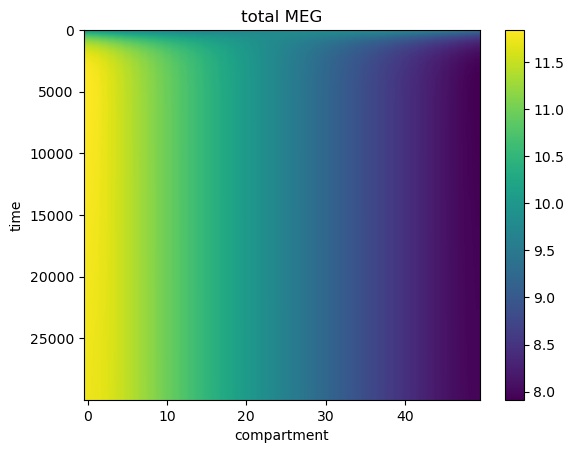

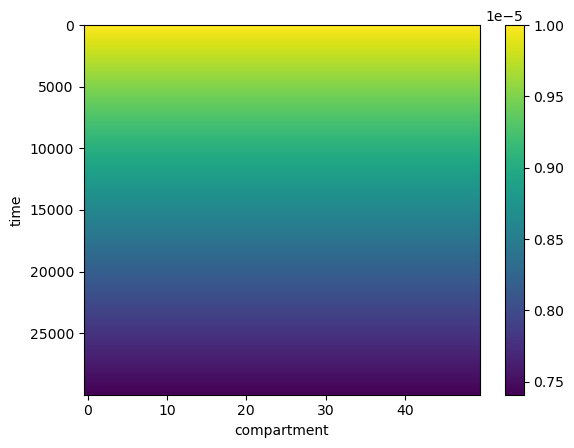

In [135]:
# seeing what the final conc. of MEG is without PG formation at the 40% boundary -> will try Kd values around this

# trying some WT for the system above - seeing if can find reasonable Kd and n values to check mutant phenotypes with

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

#r1=4*np.pi*5
#r2=4*np.pi*0.11 
r1=0
r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

sol=odeint(need_MR_PG, init, t, params) 

total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

In [109]:
print(total_MEG[20,-1])
print(total_MEG[30,-1])

9.556605234112254
9.518265272826739


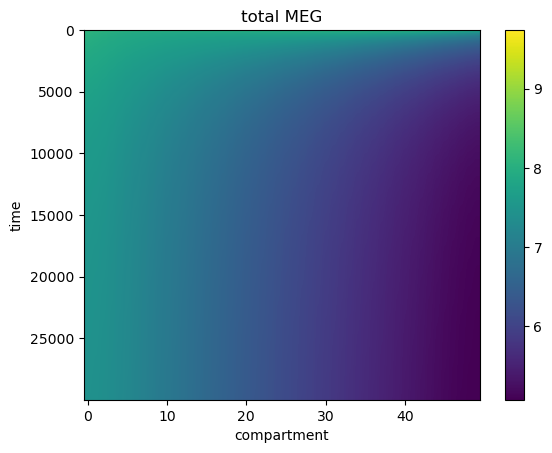

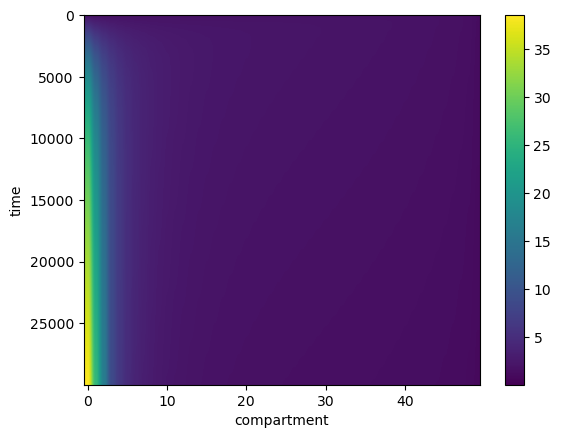

In [139]:
# trying some WT for the system above - seeing if can find reasonable Kd and n values to check mutant phenotypes with
# even with high n, can't get the 40% boundary properly as gradient is shallow in this region
# reckon the plot with the PG formation in single cpts over time (line plot) will be best?

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

sol=odeint(need_MR_PG, init, t, params) 

total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

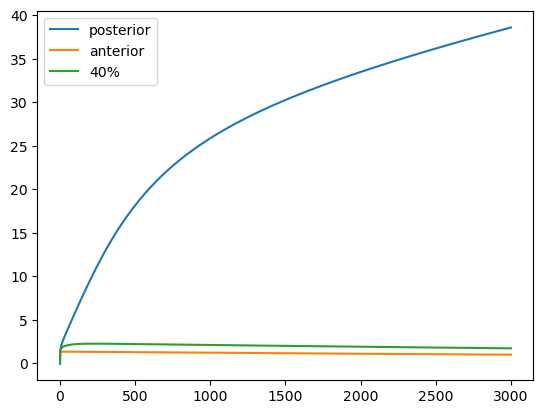

In [140]:
plt.plot(t, total_PG[:,0], label='posterior')
plt.plot(t, total_PG[:,49], label='anterior')
plt.plot(t, total_PG[:,20], label='40%')
plt.legend()
plt.show()

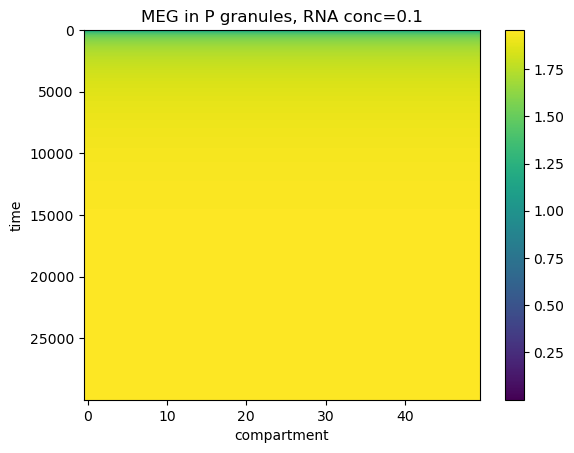

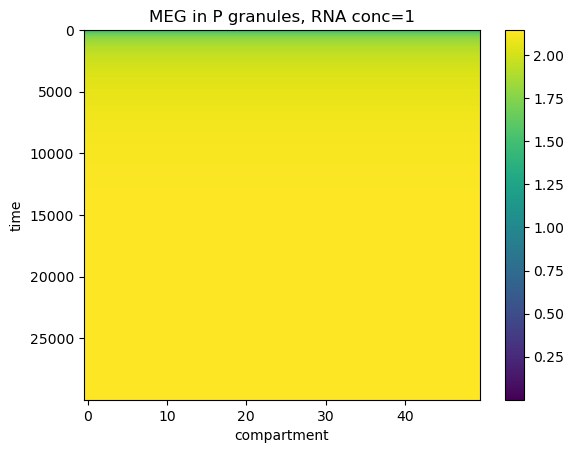

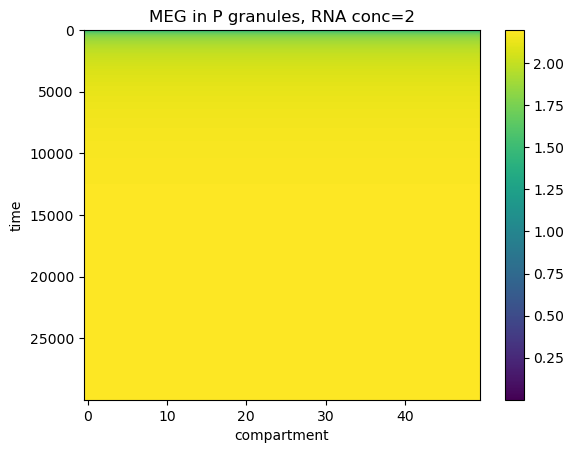

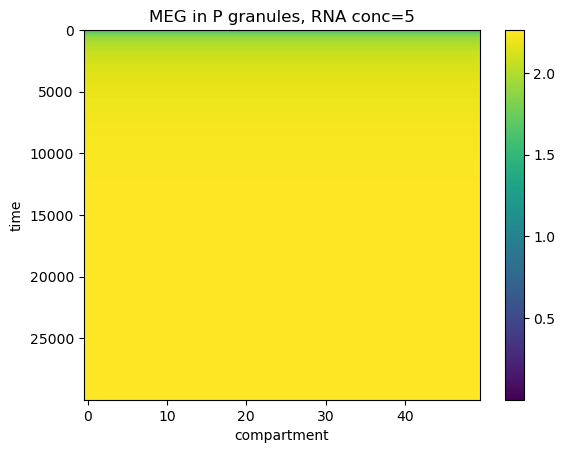

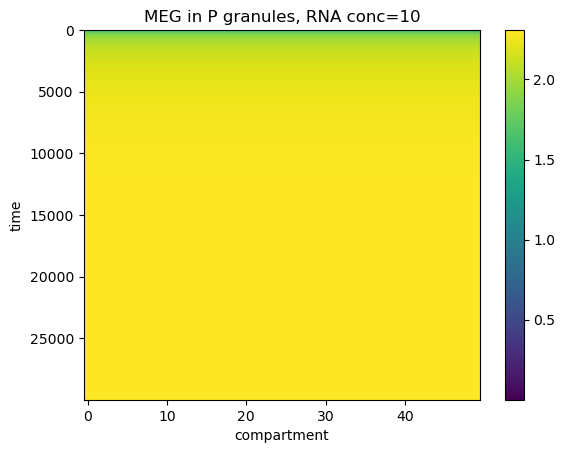

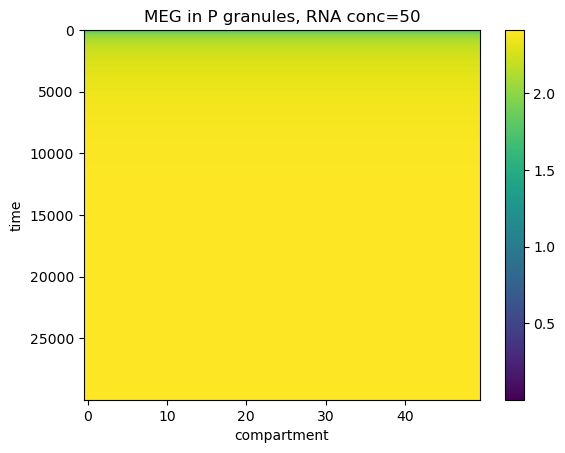

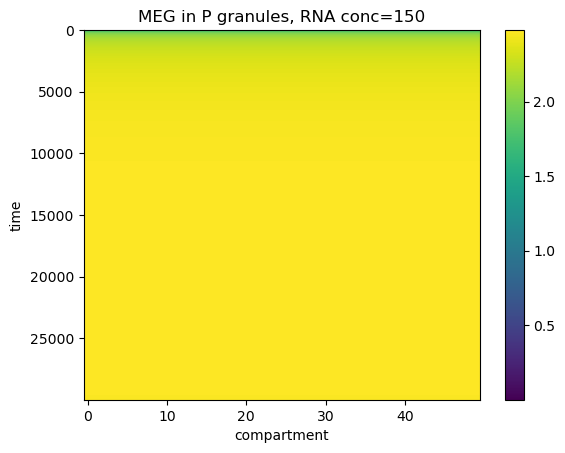

In [115]:
# mex-5 not localised -> reduce the RNA available, with no gradient. will also mean no phosphatase gradient or kinase gradient according to our model
# and phosphatase activity will be reduced
# can't make it work for the mex-5 not localised mutant

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0
kcat1_km1=10**(-7)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50


for count, RNA_conc_overall in enumerate((0.1, 1, 2, 5, 10, 50, 150)):
    RNA_overall_conc=RNA_conc_overall
    RNA_grad=0
    x=2*RNA_overall_conc/(2-RNA_grad)
    RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

    init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
    init=np.concatenate((init, RNA_conc))
    init=np.concatenate((init, np.zeros(N)))
    init=np.concatenate((init, np.zeros(2*N)))
    init=np.concatenate((init, np.ones(N)*0.00001))
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

    sol=odeint(need_MR_PG, init, t, params) 

    total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
    cs = plt.imshow(total_PG, aspect='auto')
    plt.title(f'MEG in P granules, RNA conc={RNA_conc_overall}')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.colorbar(cs)
    plt.show()

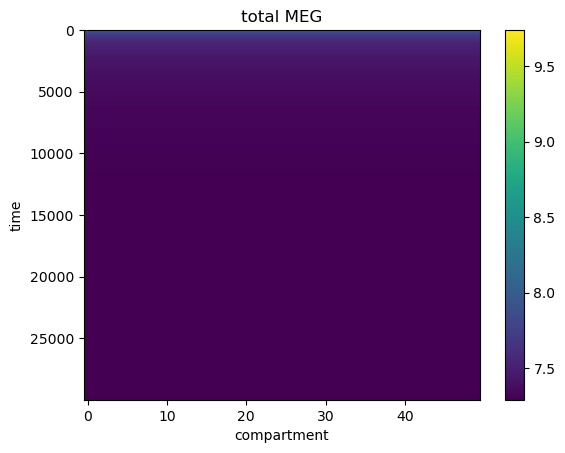

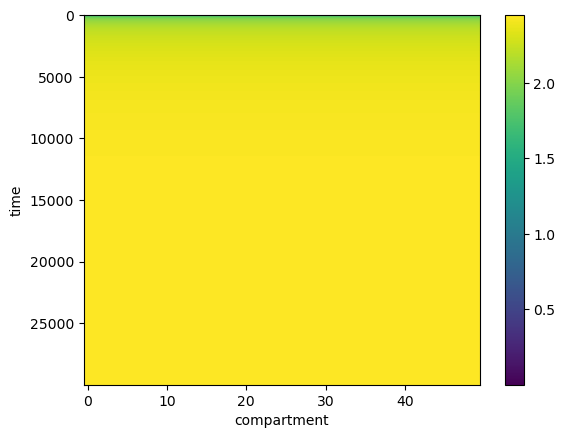

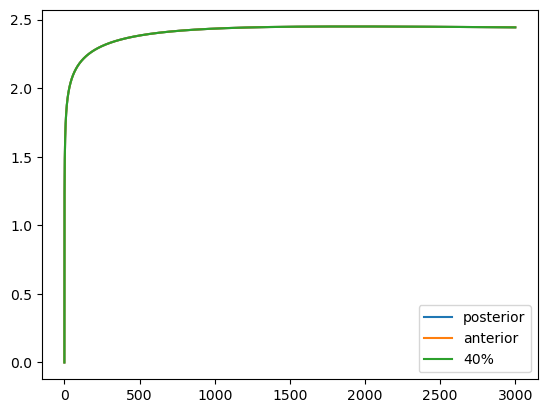

In [112]:
# mex-5 KO
# will mean no PLK-1 grad, no phosphatase grad, reduced Pase activity and no RNA grad

# get PG formation throughout, as expected
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0
kcat1_km1=9*10**(-5)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

sol=odeint(need_MR_PG, init, t, params) 

total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

plt.plot(t, total_PG[:,0], label='posterior')
plt.plot(t, total_PG[:,49], label='anterior')
plt.plot(t, total_PG[:,20], label='40%')
plt.legend()
plt.show()

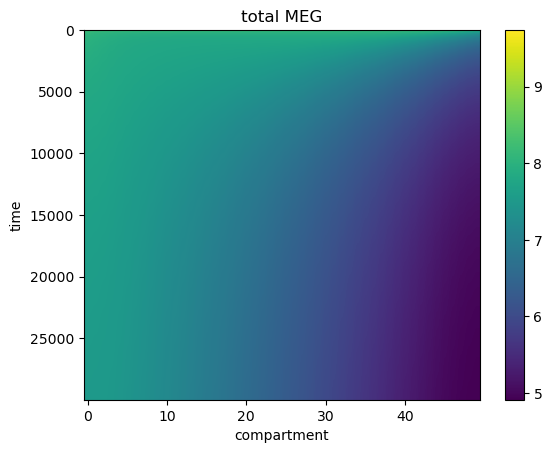

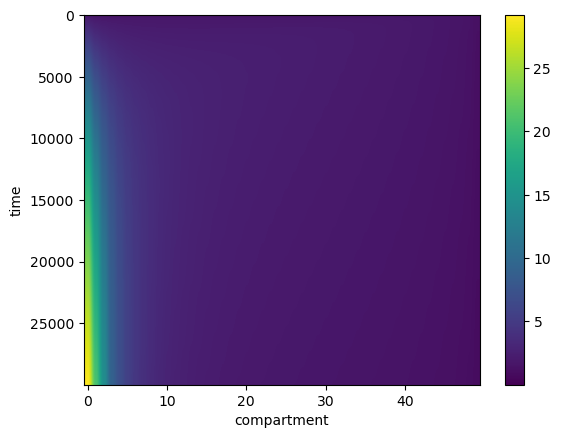

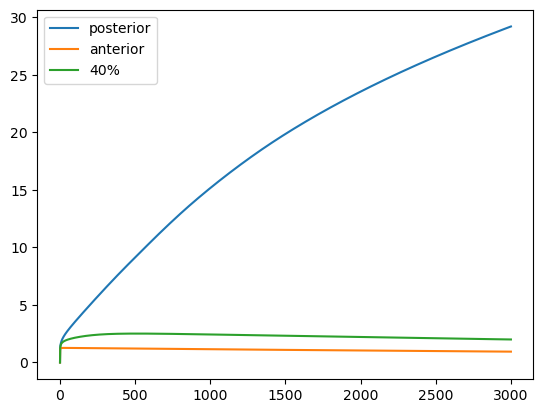

In [113]:
# plk-1 KO - expect boundary to be more anterior
# do get more PG formation more anteriorly

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=0
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))
params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, n2)

sol=odeint(need_MR_PG, init, t, params) 

total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
cs = plt.imshow(total_PG, aspect='auto')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

plt.plot(t, total_PG[:,0], label='posterior')
plt.plot(t, total_PG[:,49], label='anterior')
plt.plot(t, total_PG[:,20], label='40%')
plt.legend()
plt.show()

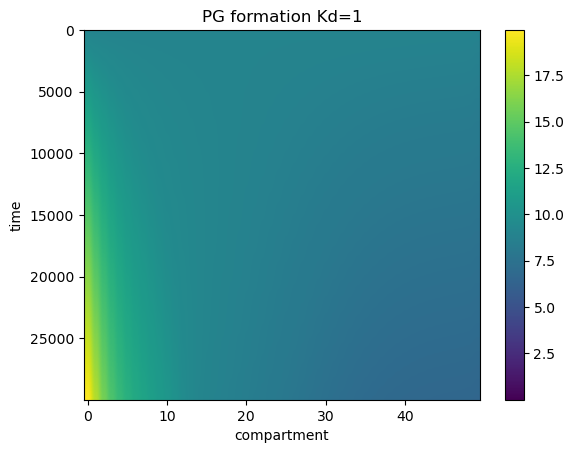

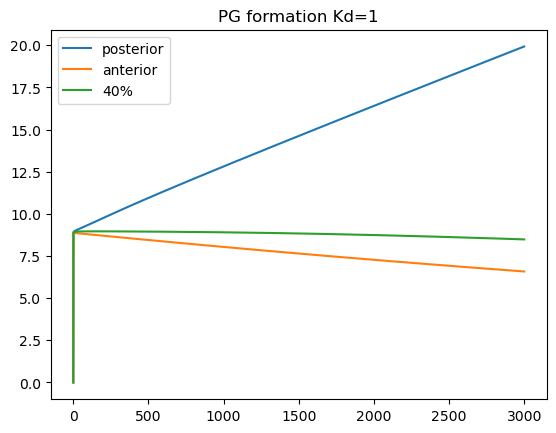

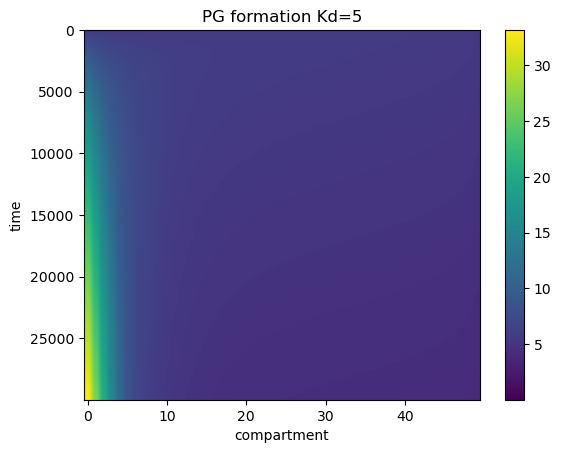

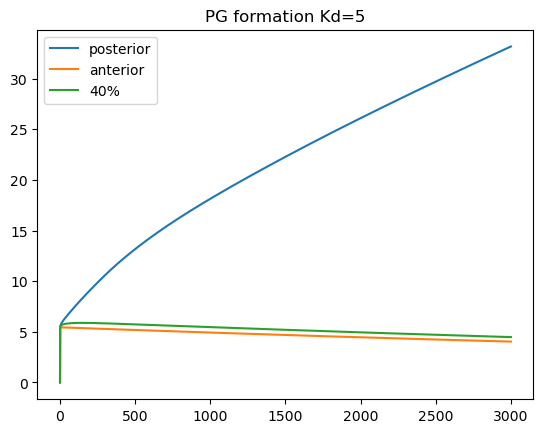

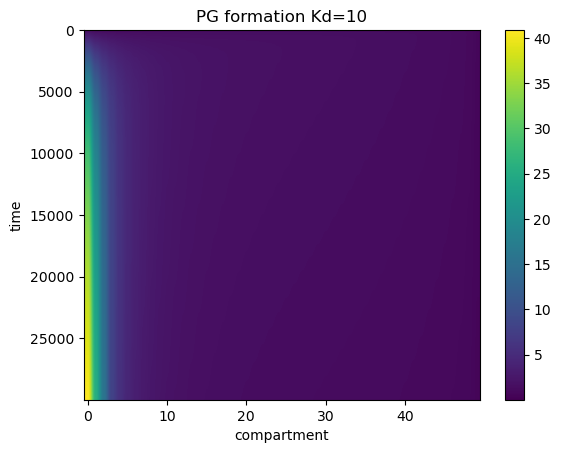

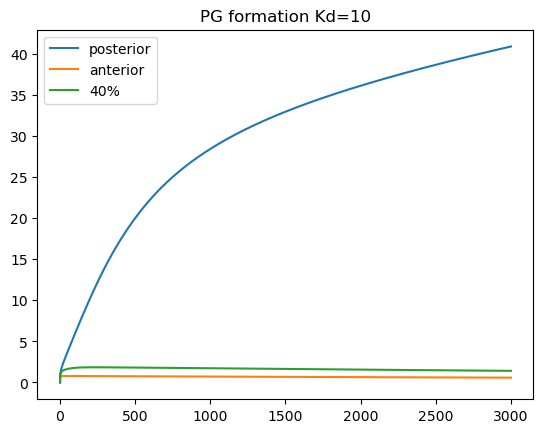

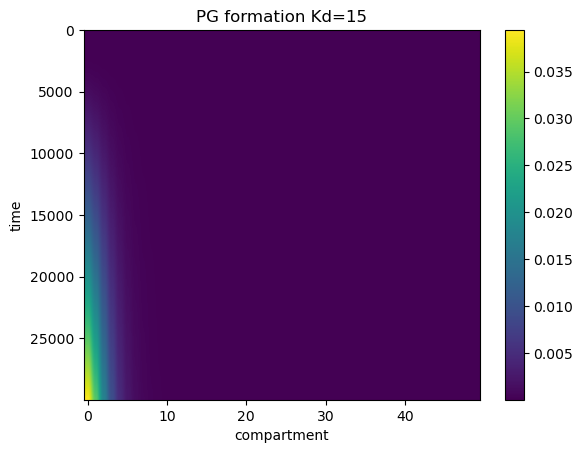

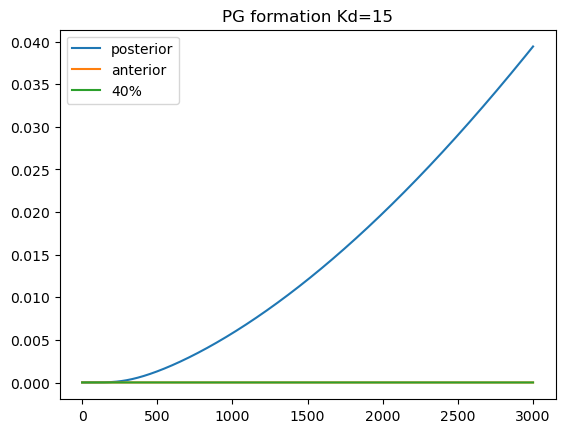

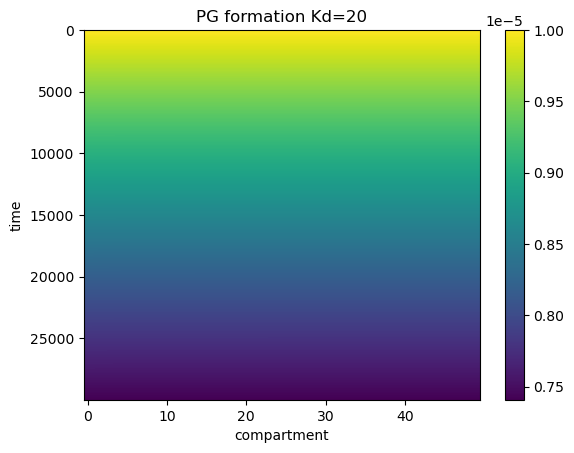

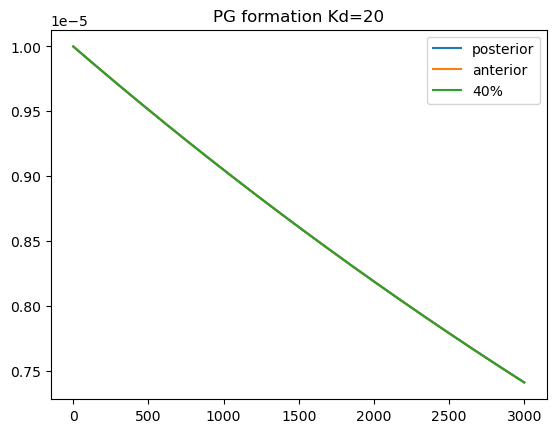

In [141]:
# seeing the effect of varying kd, n, and phosphatase parameters to see how robust posterior PG formation is in this model

# varying PG formation Kd

# trying some WT for the system above - sPG_leave_Kdif can find reasonable Kd and n values to check mutant phenotypes with
# even with high n, can't get the 40% boundary properly as gradient is shallow in this region
# reckon the plot with the PG formation in single cpts over time (line plot) will be best?

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

r1=4*np.pi*5
r2=4*np.pi*0.11 
#r1=0
#r2=0
Kd1=9.5
n1=50
Kd2=9.5
n2=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)
    
init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
init=np.concatenate((init, np.zeros(2*N)))
init=np.concatenate((init, np.ones(N)*0.00001))


for count, PG_form_Kd in enumerate((1,5,10,15,20)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, PG_form_Kd, n1, Kd2, n2)
    sol=odeint(need_MR_PG, init, t, params) 

    total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
    cs = plt.imshow(total_PG, aspect='auto')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.title(f'PG formation Kd={PG_form_Kd}')
    plt.colorbar(cs)
    plt.show()
    
    plt.plot(t, total_PG[:,0], label='posterior')
    plt.plot(t, total_PG[:,49], label='anterior')
    plt.plot(t, total_PG[:,20], label='40%')
    plt.title(f'PG formation Kd={PG_form_Kd}')
    plt.legend()
    plt.show()

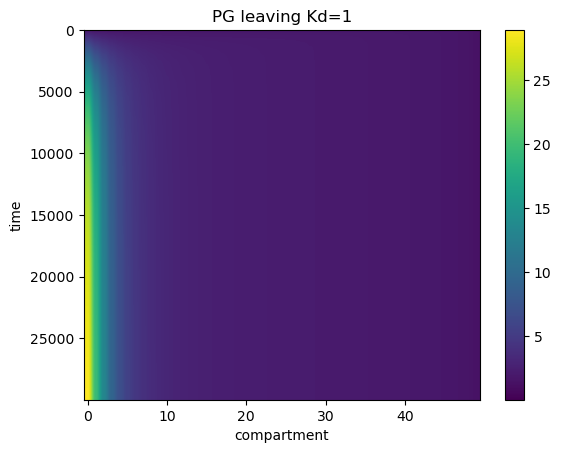

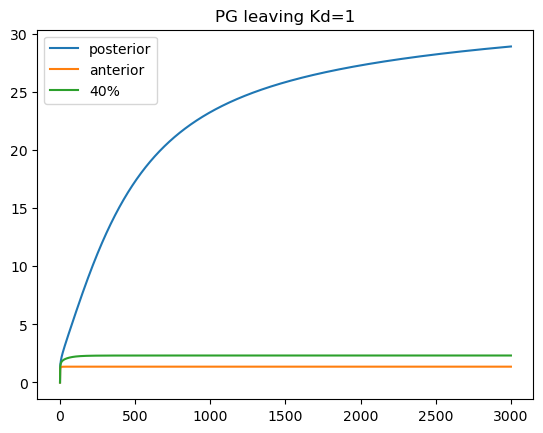

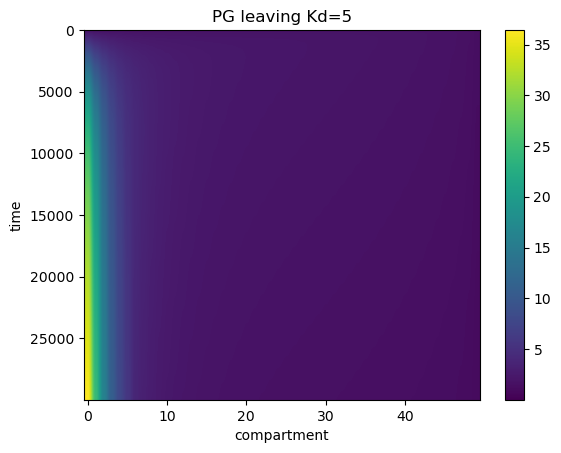

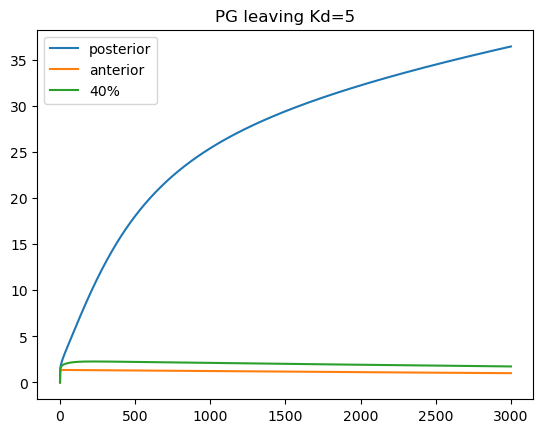

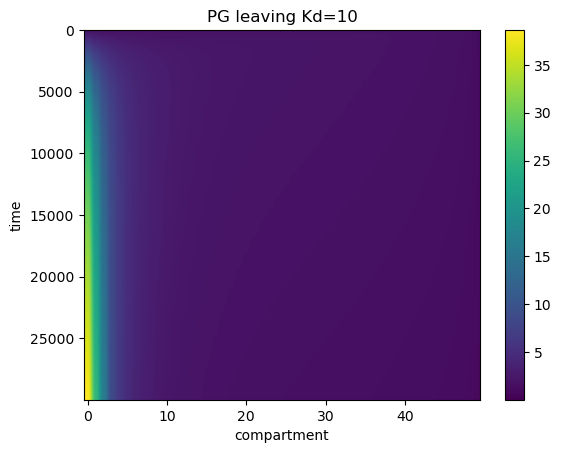

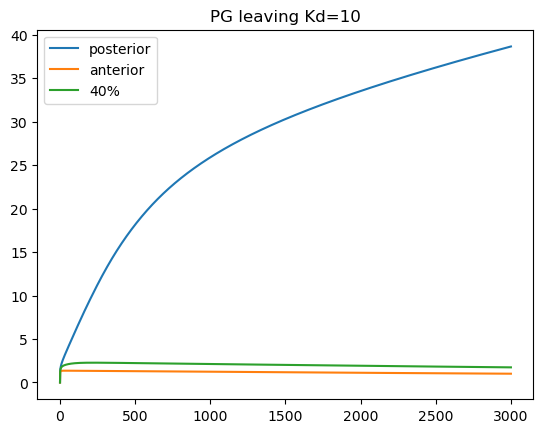

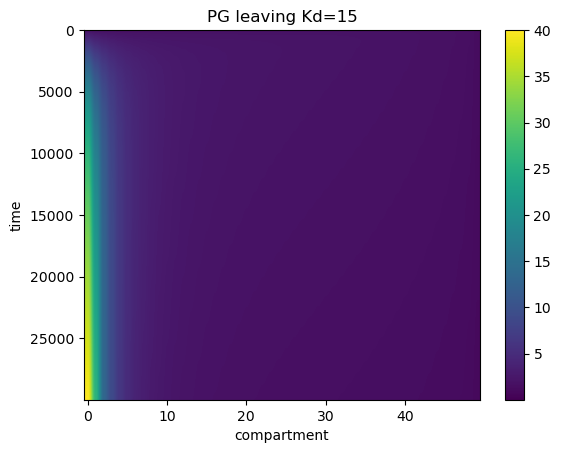

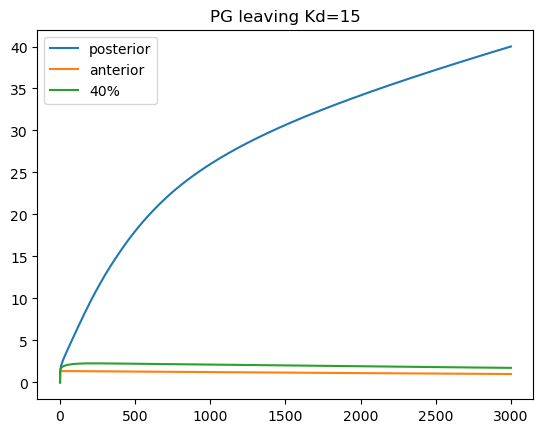

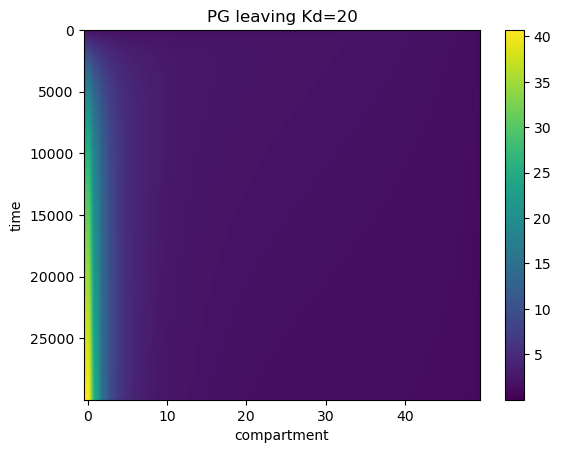

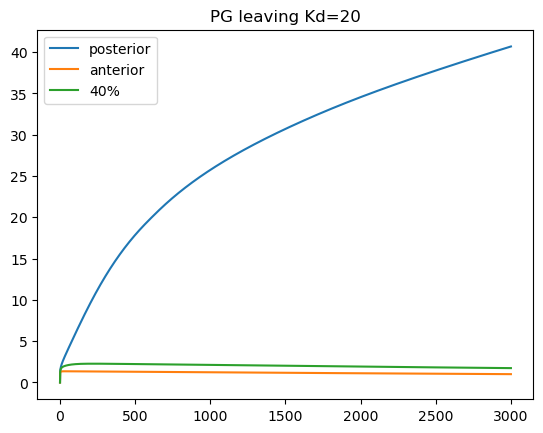

In [142]:
# varying PG leaving Kd

for count, PG_leave_Kd in enumerate((1,5,10,15,20)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, PG_leave_Kd, n2)
    sol=odeint(need_MR_PG, init, t, params) 

    total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
    cs = plt.imshow(total_PG, aspect='auto')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.title(f'PG leaving Kd={PG_leave_Kd}')
    plt.colorbar(cs)
    plt.show()
    
    plt.plot(t, total_PG[:,0], label='posterior')
    plt.plot(t, total_PG[:,49], label='anterior')
    plt.plot(t, total_PG[:,20], label='40%')
    plt.title(f'PG leaving Kd={PG_leave_Kd}')
    plt.legend()
    plt.show()

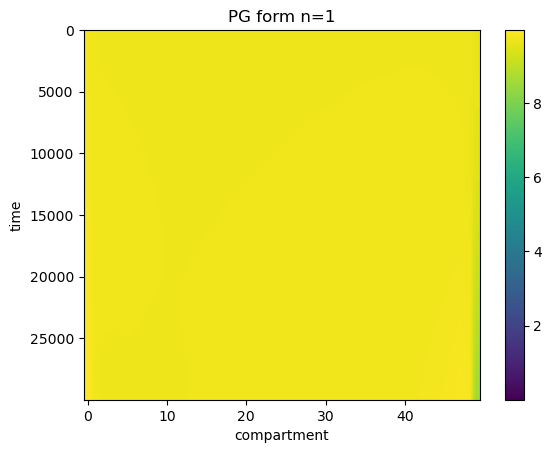

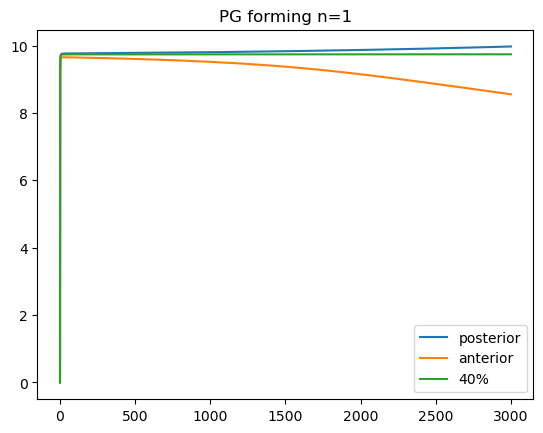

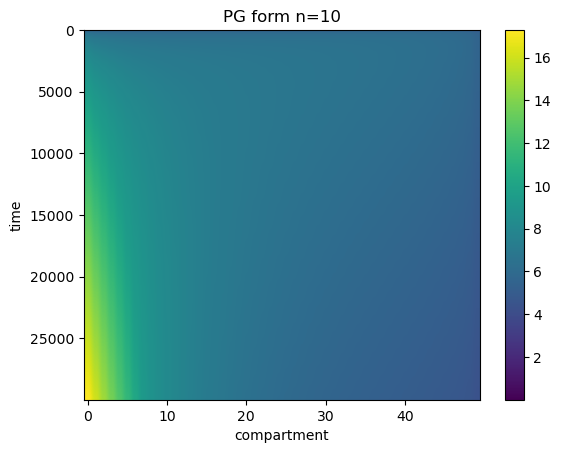

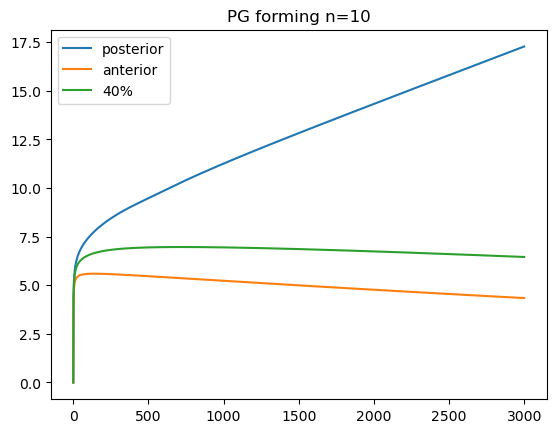

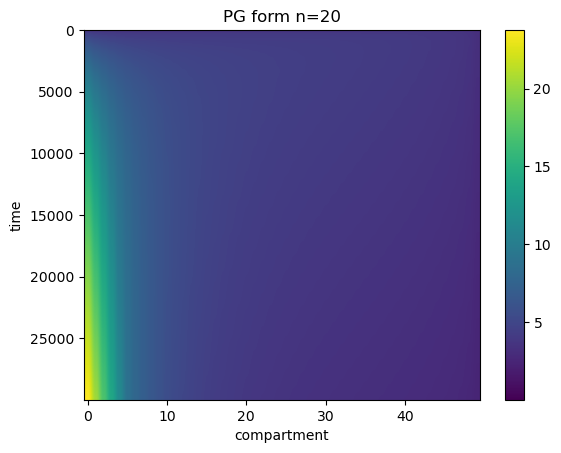

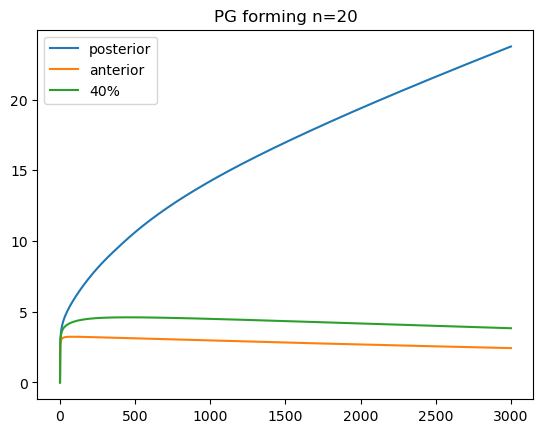

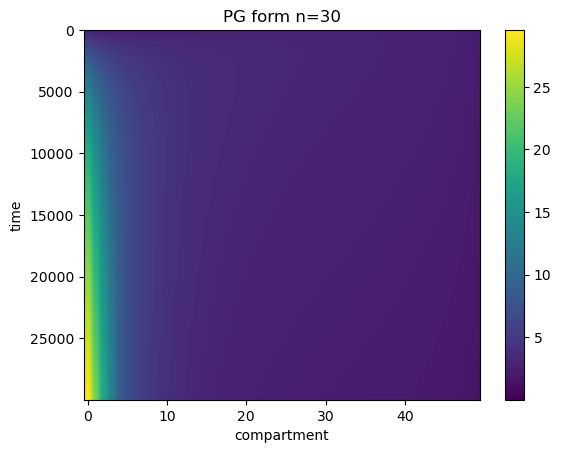

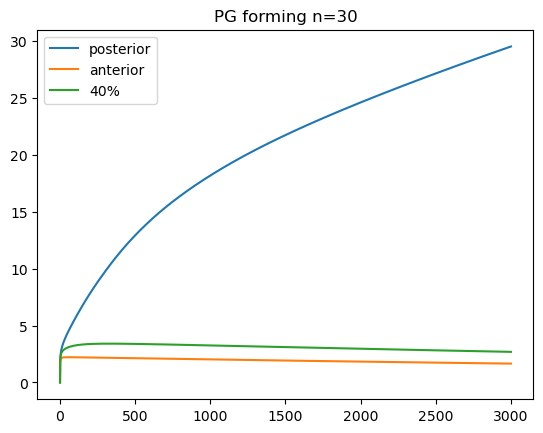

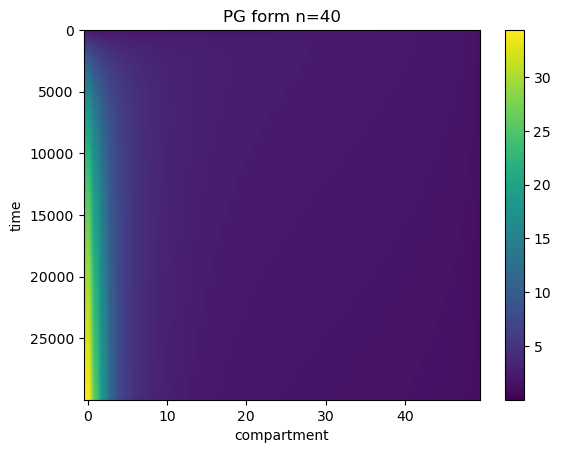

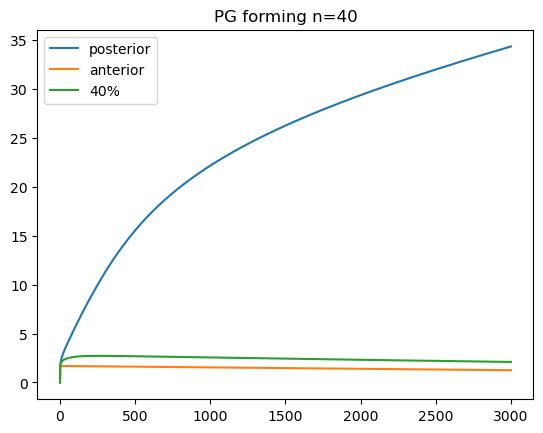

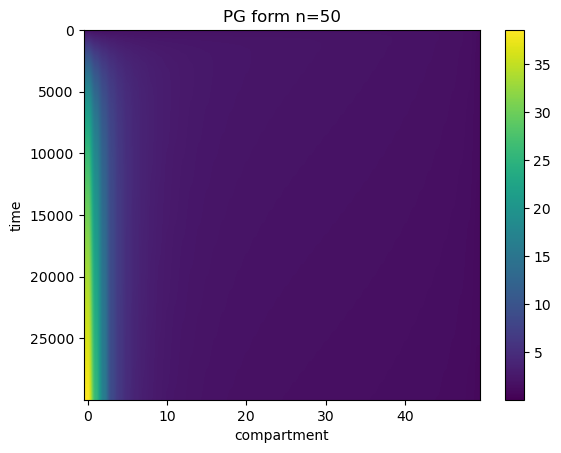

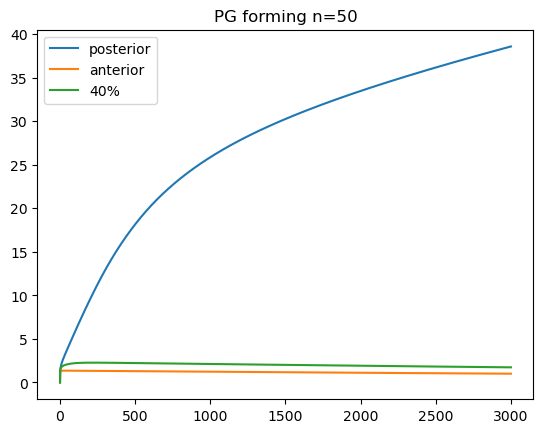

In [128]:
# varying PG formation n

for count, PG_form_n in enumerate((1,10,20,30,40,50)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, PG_form_n, Kd2, n2)
    sol=odeint(need_MR_PG, init, t, params) 

    total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
    cs = plt.imshow(total_PG, aspect='auto')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.title(f'PG form n={PG_form_n}')
    plt.colorbar(cs)
    plt.show()
    
    plt.plot(t, total_PG[:,0], label='posterior')
    plt.plot(t, total_PG[:,49], label='anterior')
    plt.plot(t, total_PG[:,20], label='40%')
    plt.title(f'PG forming n={PG_form_n}')
    plt.legend()
    plt.show()

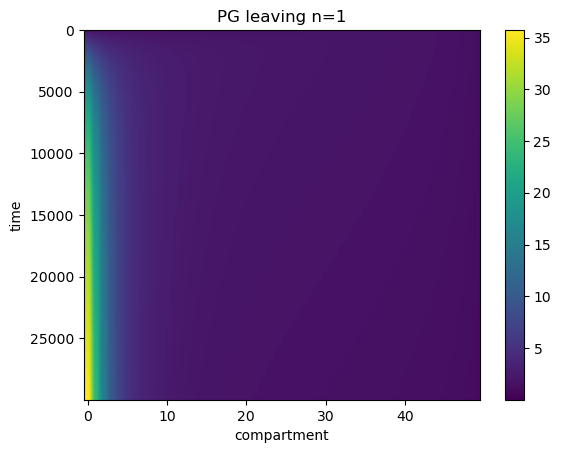

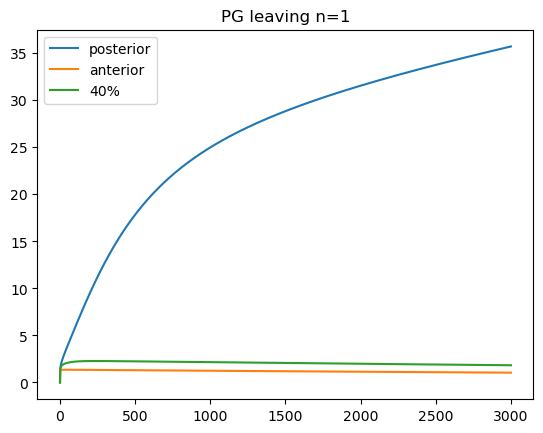

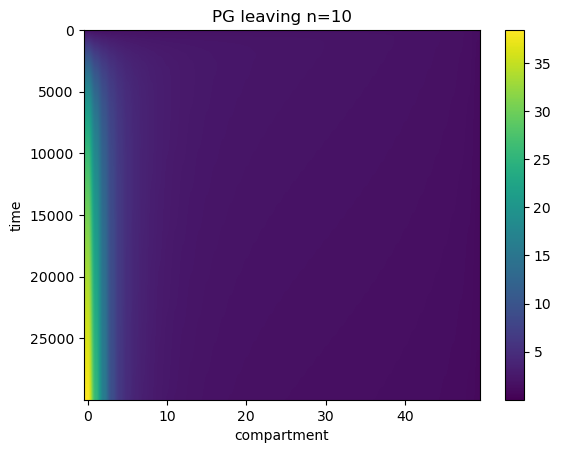

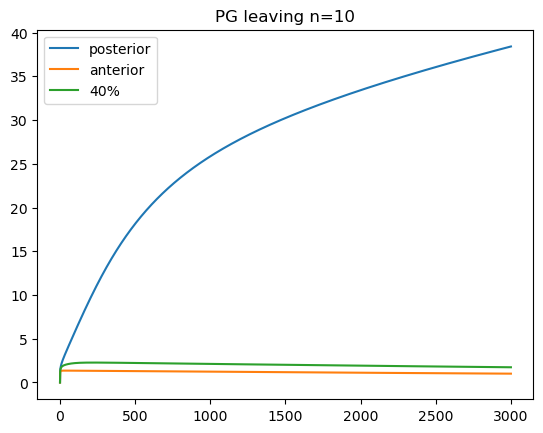

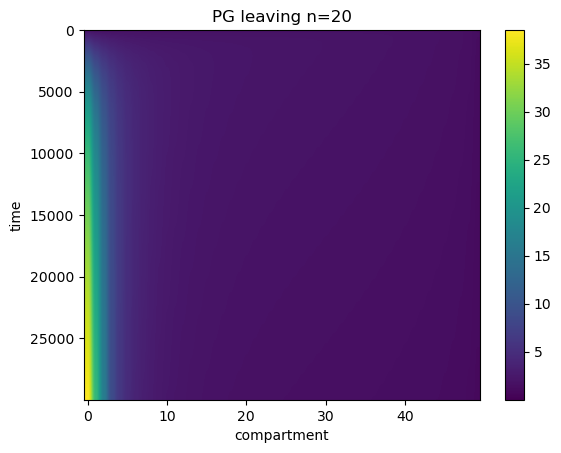

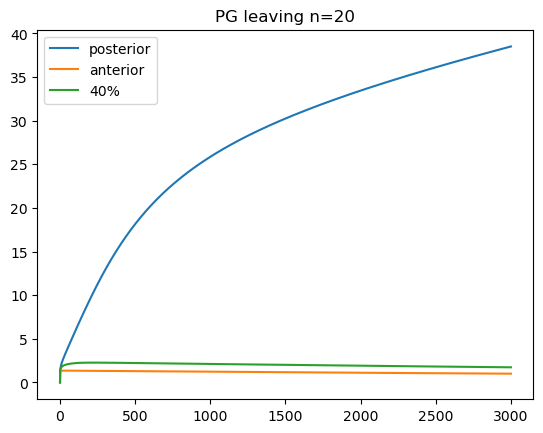

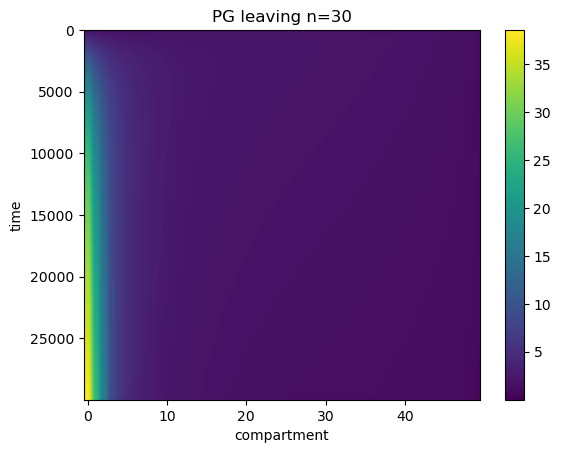

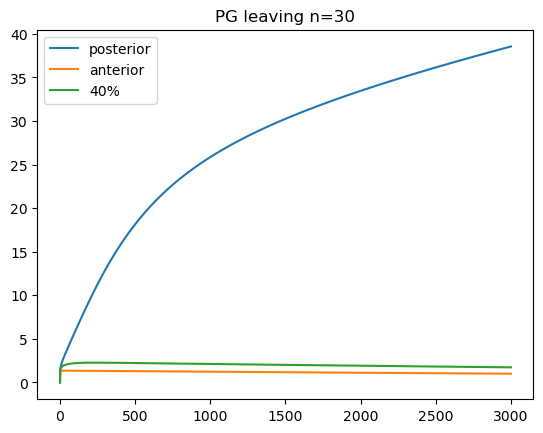

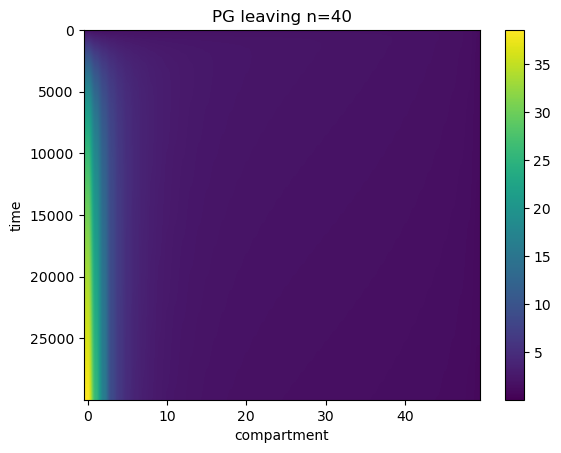

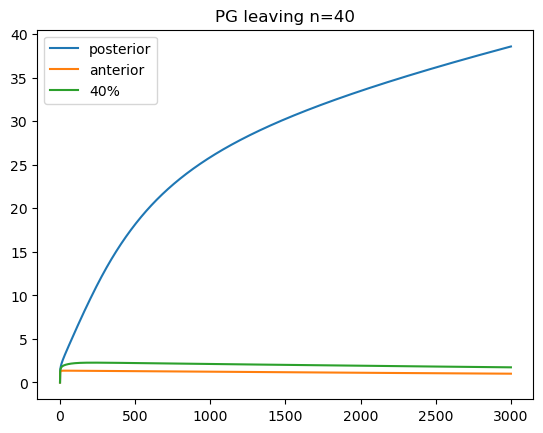

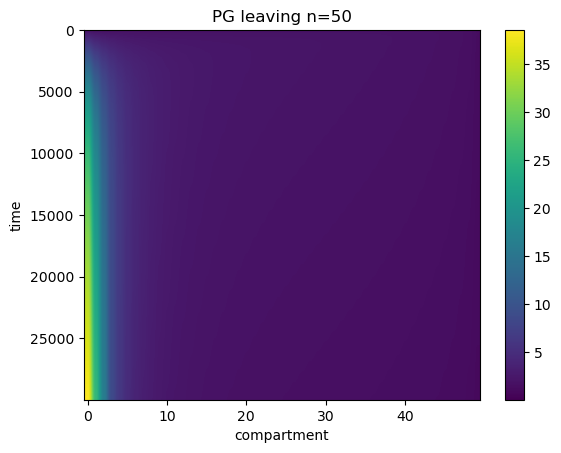

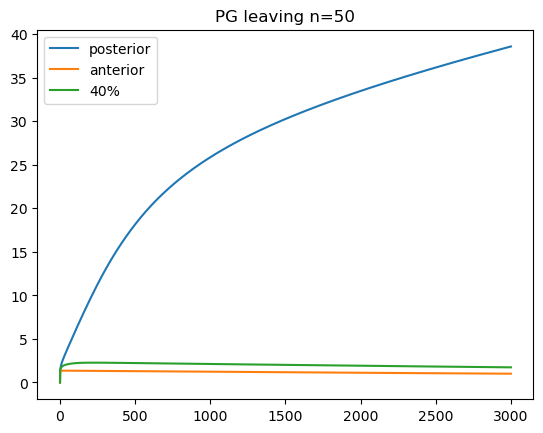

In [146]:
# varying PG leaving n

for count, PG_leave_n in enumerate((1,10,20,30,40,50)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, PG_leave_n)
    
    sol=odeint(need_MR_PG, init, t, params) 

    total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
    cs = plt.imshow(total_PG, aspect='auto')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.title(f'PG leaving n={PG_leave_n}')
    plt.colorbar(cs)
    plt.show()
    
    plt.plot(t, total_PG[:,0], label='posterior')
    plt.plot(t, total_PG[:,49], label='anterior')
    plt.plot(t, total_PG[:,20], label='40%')
    plt.title(f'PG leaving n={PG_leave_n}')
    plt.legend()
    plt.show()

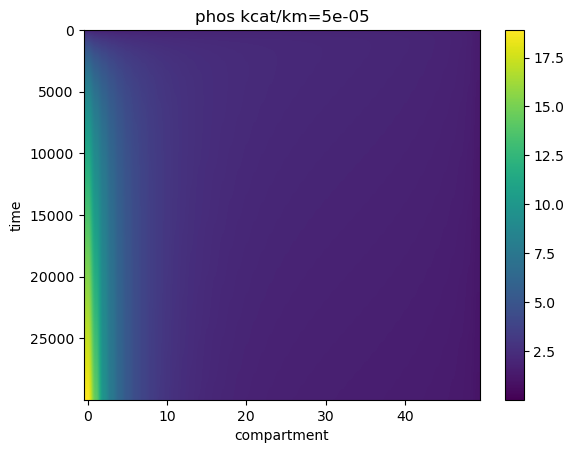

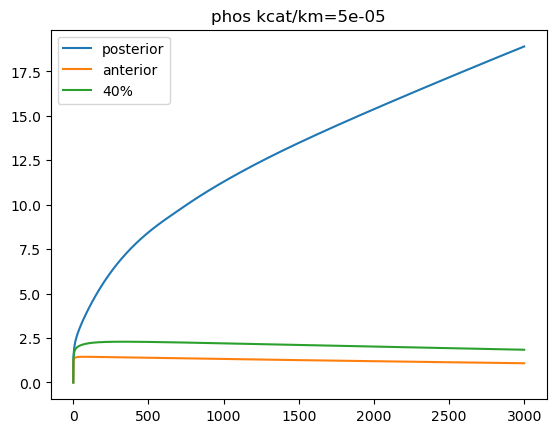

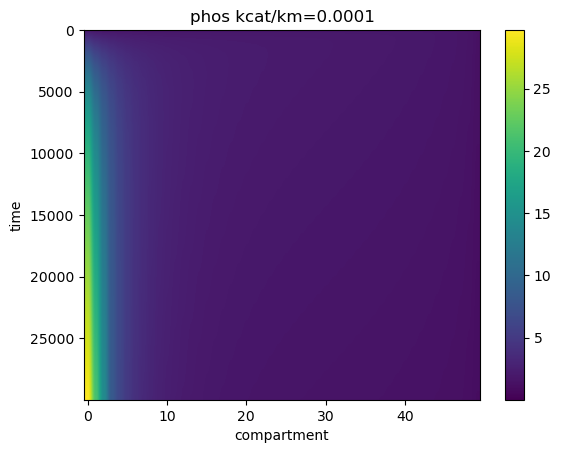

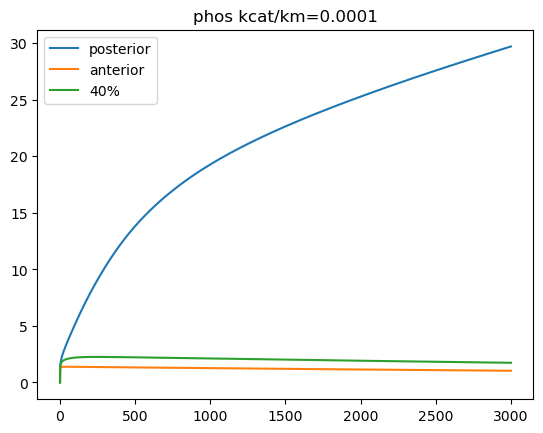

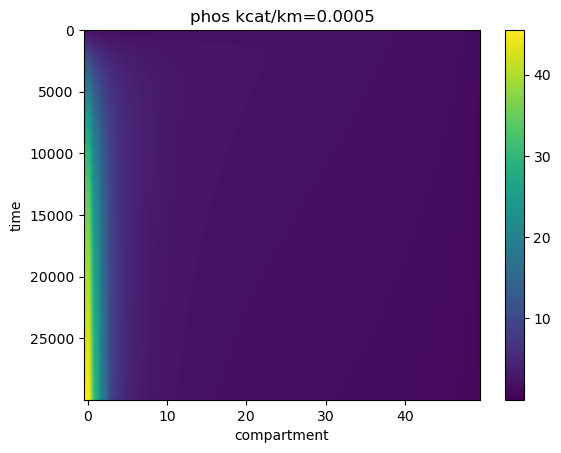

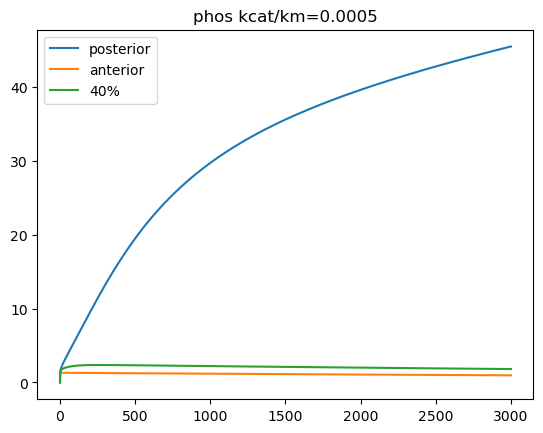

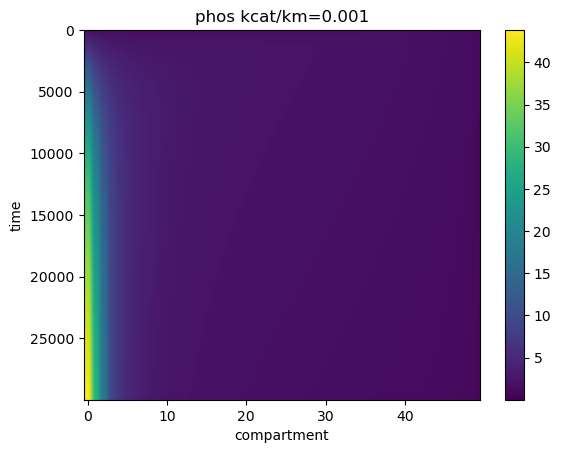

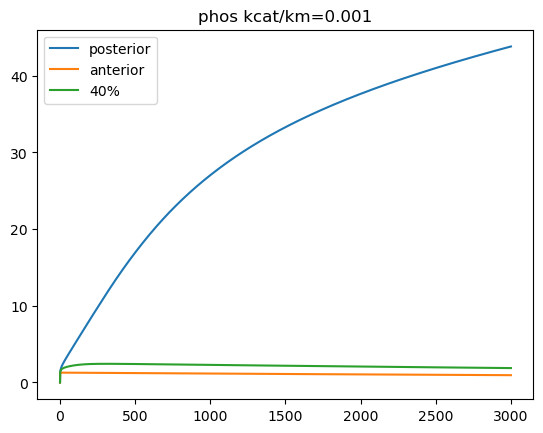

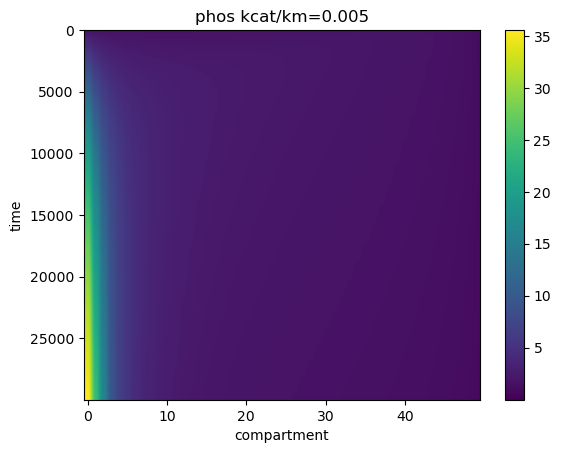

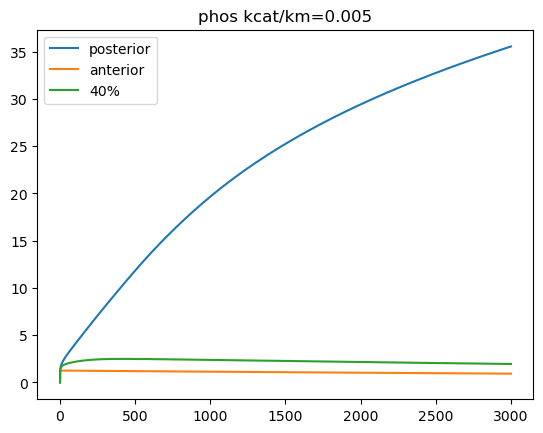

In [125]:
# varying phosphatase conc and kinetics

for count, phos_kinetics in enumerate((5*10**(-5), 1*10**(-4), 5*10**(-4), 1*10**(-3), 5*10**(-3))):
    params=(N, phos_kinetics, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, PG_leave_n)
    sol=odeint(need_MR_PG, init, t, params)
    
    total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
    cs = plt.imshow(total_PG, aspect='auto')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.title(f'phos kcat/km={phos_kinetics}')
    plt.colorbar(cs)
    plt.show()
    
    plt.plot(t, total_PG[:,0], label='posterior')
    plt.plot(t, total_PG[:,49], label='anterior')
    plt.plot(t, total_PG[:,20], label='40%')
    plt.title(f'phos kcat/km={phos_kinetics}')
    plt.legend()
    plt.show()

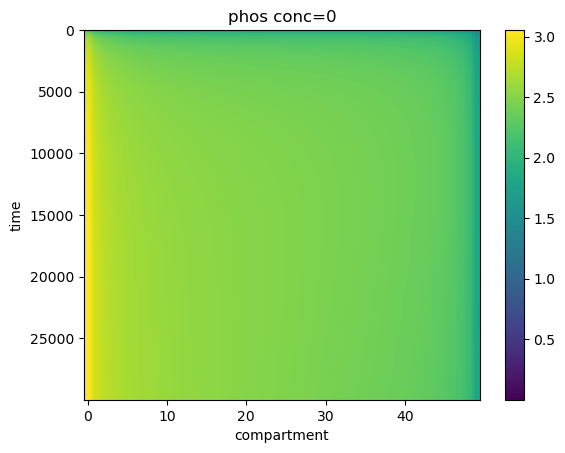

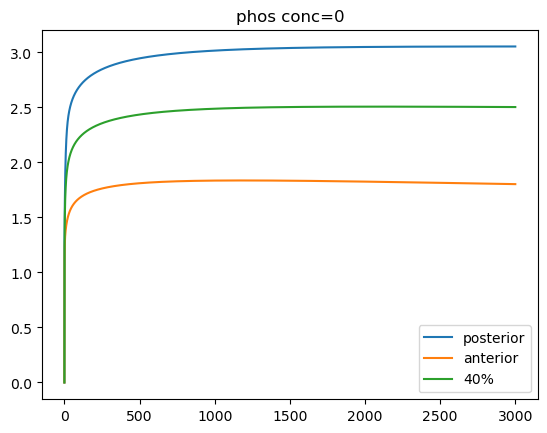

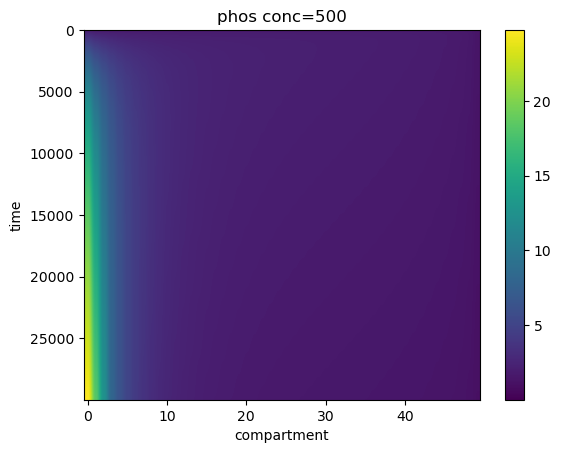

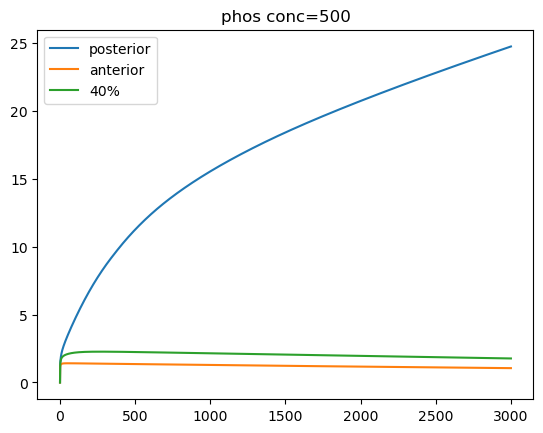

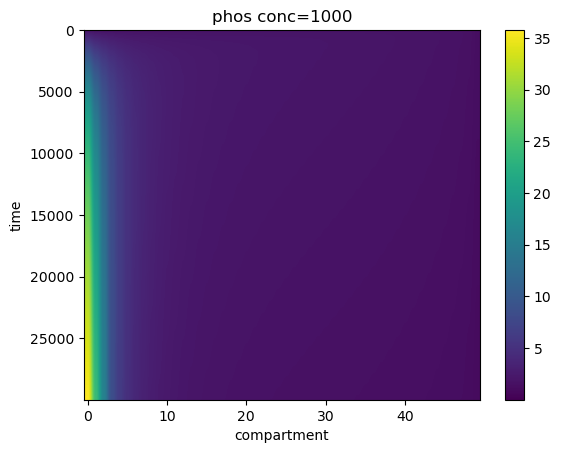

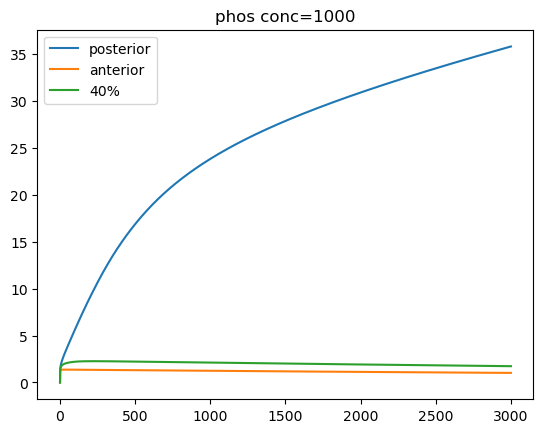

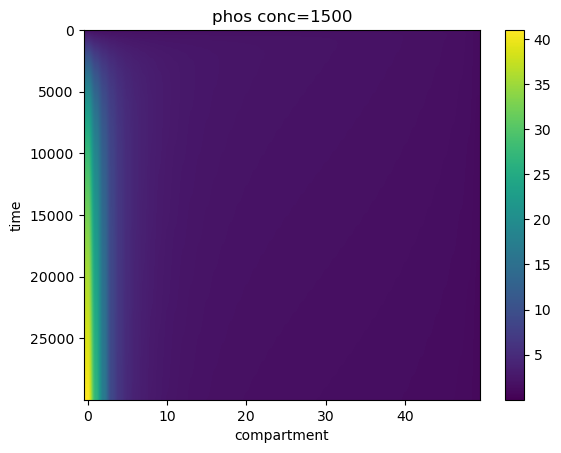

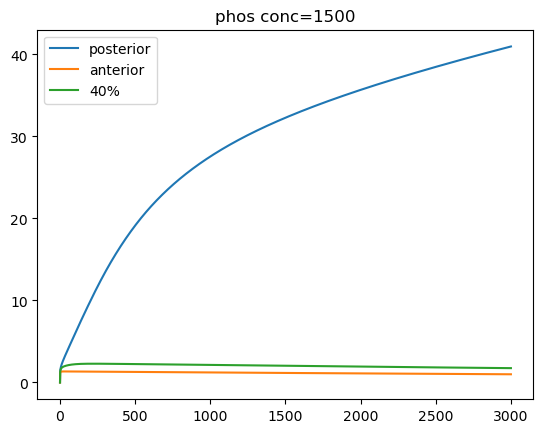

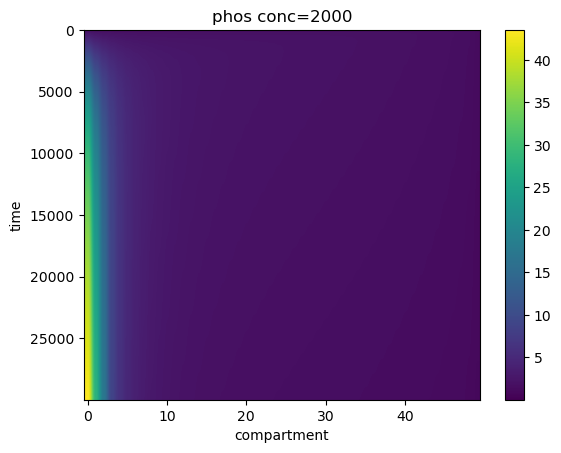

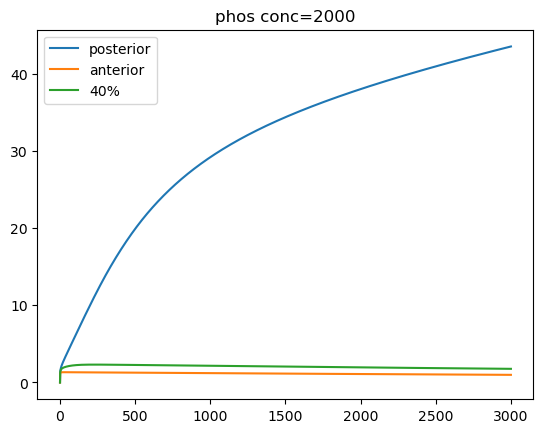

In [127]:
for count, phos_conc in enumerate((0, 500, 1000, 1500, 2000)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad, r1, r2, Kd1, n1, Kd2, PG_leave_n)
    sol=odeint(need_MR_PG, init, t, params)
    
    total_PG = sol[:, range(4*N,5*N)]+sol[:,range(5*N,6*N)]+sol[:,range(6*N,7*N)]
    cs = plt.imshow(total_PG, aspect='auto')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.title(f'phos conc={phos_conc}')
    plt.colorbar(cs)
    plt.show()
    
    plt.plot(t, total_PG[:,0], label='posterior')
    plt.plot(t, total_PG[:,49], label='anterior')
    plt.plot(t, total_PG[:,20], label='40%')
    plt.title(f'phos conc={phos_conc}')
    plt.legend()
    plt.show() 